In [3]:
import pickle
import numpy as np
import matplotlib.pyplot
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import keras

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


Leitura dos arquivos atraves do api

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import os

path = 'gdrive/My Drive/Colab Notebooks/andamentos_tjsp.pkl'
data = pd.read_pickle(path)
data.head()

,Processo,data,descricao,timedelta,acao,seq
123557,218a98942855ddf259f6ea0bee343b67,1973-05-17,Distribuição Livre Conforme remessa ao Distrib...,11079.0,Inventário e Partilha,1
128428,4bf8c065bc0f776b3598c3990b9ed8c0,1979-09-10,Distribuído por Direcionamento (movimentação e...,13534.0,Inventário e Partilha,1
97535,a9b501b6b76a7eff441ebf5d9c3ec872,1980-04-30,Distribuído por Direcionamento (movimentação e...,12375.0,Desapropriação,1
131228,2fdc177c5ec4f2e2743ac65e0cefd0e4,1980-11-28,Distribuição Livre Processo Distribuído por So...,8859.0,NaN,1
143392,09e89309dde68184c0c4997f19691668,1990-02-13,Incidente Processual Incidente Processual 583....,30.0,Recuperação judicial e Falência,1


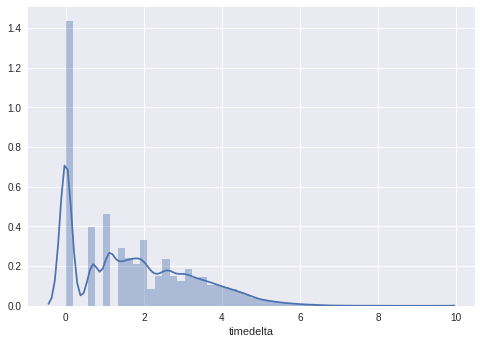

In [24]:
sns.distplot(np.log(data['timedelta']))
plt.show()

## Carregando os stopwords

Carregando stopwords br

In [0]:
file = 'gdrive/My Drive/Colab Notebooks/stopwords.txt'


with open(file,'r') as file:
  stopwords = file.read().split('\n')

stopwords = [word.strip() for word in stopwords]

# Teste do spacy

Primeiramente devemos instalar o pacote portuguese do spacy para utilizar o processador de linguagem natural em português.


In [47]:
!python -m spacy download pt

    100% |████████████████████████████████| 38.7MB 48.8MB/s 
  Running setup.py install for pt-core-news-sm ... - \ | done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/pt

    You can now load the model via spacy.load('pt')



In [0]:
from keras.preprocessing.text import Tokenizer

MAX_WORDS = 1000
MAX_LEN = 20

# Treinamos um embedding em cima das descricoes dos dados
tknz = Tokenizer(num_words=MAX_WORDS)
tknz.fit_on_texts(data.descricao)

# Criamos uma coluna para as palavras encodadas
data['encoding'] = tknz.texts_to_sequences(data.descricao)


In [0]:
from keras.preprocessing import sequence

# Crio meu conjunto de treino usando todos os encodings com uma sequencia de 
# tamanho 10 (para padronizar a entrada)

X = sequence.pad_sequences(data.encoding.values, maxlen=MAX_LEN)
y = data.timedelta

In [9]:
# Criar a rede recorrente para este problema
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=MAX_WORDS, output_dim=50, 
                                 input_length=MAX_LEN))
model.add(keras.layers.Conv1D(64,3, activation='relu'))
model.add(keras.layers.LSTM(32, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 50)            50000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 64)            9664      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 72,113
Trainable params: 72,113
Non-trainable params: 0
_________________________________________________________________


In [0]:
from sklearn.model_selection import train_test_split

# Amostragem dos conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), random_state=42,
                                                    test_size=.3)


In [12]:
model.fit(X_train, y_train,
          batch_size=X_train.shape[0]//200,
          epochs=10,
          validation_split=.1,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5)])

Train on 93506 samples, validate on 10390 samples
Epoch 1/10
93506/93506 [==============================] - 12s 125us/step - loss: 2.0087 - val_loss: 1.7049
Epoch 2/10
93506/93506 [==============================] - 10s 105us/step - loss: 1.7290 - val_loss: 1.6742
Epoch 3/10
93506/93506 [==============================] - 10s 106us/step - loss: 1.6755 - val_loss: 1.6821
Epoch 4/10
93506/93506 [==============================] - 10s 106us/step - loss: 1.6533 - val_loss: 1.6620
Epoch 5/10
93506/93506 [==============================] - 10s 103us/step - loss: 1.6306 - val_loss: 1.6985
Epoch 6/10
93506/93506 [==============================] - 10s 103us/step - loss: 1.6092 - val_loss: 1.6309
Epoch 7/10
93506/93506 [==============================] - 10s 103us/step - loss: 1.5912 - val_loss: 1.7981
Epoch 8/10
93506/93506 [==============================] - 10s 103us/step - loss: 1.5765 - val_loss: 1.6876
Epoch 9/10
93506/93506 [==============================] - 10s 104us/step - loss: 1.5631 - val_

In [0]:
y_pred = model.predict(X_test)